**Zgony w grupach wiekowych w województwach lub do wyboru kod regionu**
Walidacja 2019


Narysować zgony 2000-2021 w Polsce tygodniowo
w rozbiciu na:
* grupy wiekowe,
* płeć.

Dane z:

https://ec.europa.eu/eurostat/web/population-demography-migration-projections/data/database?node_code=demomwk

Plik dla państw:

https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/demo_r_mwk_05.tsv.gz

Plik dla wojawództw:

https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/demo_r_mwk2_05.tsv.gz

* **Plot podświetla ostatnią linię, a powinno być do wyboru**


* Zaktualizować dane
* Policzyć zgony 2020 jako procent regresji z trendem
    * Trendy są różne dla różnych grup wiekowych i niemonotoniczne
    * Liczyć trend jako zmiany średniej rocznej z upływem lat
        * Spłaszczyć wykresy roczne, odejmując trend
        * Policzyć średnie z tygodni po wszystkich latach (po odjęciu trendu)
        * Zobaczyć na ile jesień 2020 odbiega od tak policzonej średniej
    * Uwaga! Trend kończyłby się na roku 2019
        * Piotr Pokarowski liczy trend jakoś inaczej, do ostatka
        * Robi regresję na rok 2020
    * Zwalidować: Dane dla 2020 będą odstawać od trendu przewidywanego dla 2020. Ale porównać, jak bardzo dane 2019 odstają od trendu dofitowanego dla 2019.
        * Na oko, trend jest przekrzywiony, bo minimum sezonowe jest w 30. tygodniu, a nie w 27.
* Wybieranie grup wiekowych też za pomocą pivot?


Funkcja fitowana do trendu demograficznego:

$ f(x,y)= a x^2 + b x+  c +  A (y-y_0)^2  $

$x$: Lata.

$y$: Tygodnie.

$y_0$: Minimum lub maksimum sezonowości. Jeśli jest sezonowość, to minimum lub maksimum obserwujemy w przybliżeniu środku roku.

W niektórych przypadkach fituję pełną funkcję $f(x,y)$ z parametrami fitowania: $a$, $b$, $c$, $A$, $y_0$.

W innych lepiej fituje się funkcja liniowa w latach. Wtedy ustawiam $a=0$ i parametrami fitowania są:  $b$, $c$, $A$, $y_0$.

W jeszcze innych przypadkach lepiej fituje się funkcja płaska sezonowo (w tygodniach). Wtedy ustawiam $A =0$ i parametrami fitowania są: $a$, $b$, $c$.

Z kolei w niektórych przypadkach najlepiej fituje się funkcja liniowa w latach i płaska sezonowo. Wtedy ustawiam $a=0$ i $A =0$, a parametrami fitowania są:  $b$, $c$.

**Uwaga, jak to zmienić? Sezonowość powinna być proporcjonalna do liczby zgonów**
**Chyba za dużo parametrów fitowania. Uprościć wzory**


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
from scipy import optimize

# https://stackoverflow.com/questions/33406313/how-to-match-any-string-from-a-list-of-strings-in-regular-expressions-in-python
def list_to_regex_string(str_list):
    regex_string = r"(?=(\b" + '\\b|\\b'.join(str_list) + r"\b))"
    return regex_string 


# https://stackoverflow.com/questions/25936746/create-a-function-decorator-that-logs-arguments
def logger(prefix, show_first_argument=False):
    def decorate(f):
        def wrapper(*args, **kwargs):
            if show_first_argument:
                print(prefix, args[0])
            else:
                print(prefix)
            cr = f(*args, **kwargs)
            return cr
        return wrapper
    return decorate

@logger("Read file:",show_first_argument=True)
def read_dataframe(file, sep='\t'):
    df = pd.read_csv(file,low_memory=False, sep=sep)
    return df


def select_country(df, country_code):
    return df[df.iloc[:,0].str.contains(","+country_code, regex=False)]
    
def replace_with_nan(df):
    df.replace(': ' , np.nan, inplace=True)
    return

@logger("Removing \'p\' postscript (\'provisionary\')")
def clean_p(df):
    df.replace(' p' , '', inplace=True, regex=True)
    return

def to_numbers(df):
    numeric_columns = df.columns[1:]
    df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce', axis=1)
    return







# def split_column(df, column_label):
#     new_column_labels = column_label.split(',')
#     df[column_label ]= df[column_label ].astype(str) 
#     df[new_column_labels ]= df[column_label ].str.split(',',expand=True)
#     return

# def move_split_columns_to_front(df, column_label):
#     new_column_labels = column_label.split(',')
#     tmp = df[new_column_labels] 
#     df.drop(labels=new_column_labels , axis=1,inplace = True)
#     df.drop(labels=[column_label ] , axis=1,inplace = True)
#     for i in reversed(range(0,4)):
#         df.insert(0, new_column_labels[i] , tmp.iloc[:,i]) 
#     return

# def split_first_column(df):
#     column_label = 'age,sex,unit,geo\\time'
    
#     split_column(df, column_label)
#     move_split_columns_to_front(df, column_label)
#     return

def first_row_to_header(df):
    df.rename(columns=df.iloc[0], inplace=True)
    df.drop('age,sex,unit,geo\\time', inplace=True)
    return df

def reverse_rows(df):
    df = df.iloc[::-1]
    return df

# To działa tylko dla Polski, a powinno dla dowolnego kraju
def sort_columns(df):
    list = ['TOTAL,F,NR,PL', 'TOTAL,M,NR,PL', 'TOTAL,T,NR,PL', 'UNK,F,NR,PL',
       'UNK,M,NR,PL', 'UNK,T,NR,PL', 
        'Y_LT5,F,NR,PL', 'Y_LT5,M,NR,PL', 'Y_LT5,T,NR,PL',
        'Y5-9,F,NR,PL', 'Y5-9,M,NR,PL',
       'Y5-9,T,NR,PL',
       'Y10-14,F,NR,PL', 'Y10-14,M,NR,PL',
       'Y10-14,T,NR,PL', 
       'Y15-19,F,NR,PL', 'Y15-19,M,NR,PL', 'Y15-19,T,NR,PL',
       'Y20-24,F,NR,PL', 'Y20-24,M,NR,PL', 'Y20-24,T,NR,PL', 
       'Y25-29,F,NR,PL',
       'Y25-29,M,NR,PL', 'Y25-29,T,NR,PL', 'Y30-34,F,NR,PL', 'Y30-34,M,NR,PL',
       'Y30-34,T,NR,PL', 'Y35-39,F,NR,PL', 'Y35-39,M,NR,PL', 'Y35-39,T,NR,PL',
       'Y40-44,F,NR,PL', 'Y40-44,M,NR,PL', 'Y40-44,T,NR,PL', 'Y45-49,F,NR,PL',
       'Y45-49,M,NR,PL', 'Y45-49,T,NR,PL',  'Y50-54,F,NR,PL', 'Y50-54,M,NR,PL', 'Y50-54,T,NR,PL',
       'Y55-59,F,NR,PL', 'Y55-59,M,NR,PL', 'Y55-59,T,NR,PL', 'Y60-64,F,NR,PL',
       'Y60-64,M,NR,PL', 'Y60-64,T,NR,PL', 'Y65-69,F,NR,PL', 'Y65-69,M,NR,PL',
       'Y65-69,T,NR,PL', 'Y70-74,F,NR,PL', 'Y70-74,M,NR,PL', 'Y70-74,T,NR,PL',
       'Y75-79,F,NR,PL', 'Y75-79,M,NR,PL', 'Y75-79,T,NR,PL', 'Y80-84,F,NR,PL',
       'Y80-84,M,NR,PL', 'Y80-84,T,NR,PL', 'Y85-89,F,NR,PL', 'Y85-89,M,NR,PL',
       'Y85-89,T,NR,PL', 'Y_GE90,F,NR,PL', 'Y_GE90,M,NR,PL', 'Y_GE90,T,NR,PL',
       ]
    return df.reindex(list, axis=1)


def make_age_groups_dict():
    age_groups_dict={
        0:'Y_LT5',
        5:'Y5-9',
        10:'Y10-14',
        15:'Y15-19',
        20:'Y20-24',
        25:'Y25-29',
        30:'Y30-34',
        35:'Y35-39',
        40:'Y40-44',
        45:'Y45-49',
        50:'Y50-54',
        55:'Y55-59',
        60:'Y60-64',
        65:'Y65-69',
        70:'Y70-74',
        75:'Y75-79',
        80:'Y80-84',
        85:'Y85-89',
        90:'Y_GE90' 
    }
    return age_groups_dict


def make_age_groups_verbose_dict():
    age_groups_verbose_dict={
        0:'< 5 years',
        5:'5-9 years',
        10:'10-14 years',
        15:'15-19 years',
        20:'20-24 years',
        25:'25-29 years',
        30:'30-34 years',
        35:'35-39 years',
        40:'40-44 years',
        45:'45-49 years',
        50:'50-54 years',
        55:'55-59 years',
        60:'60-64 years',
        65:'65-69 years',
        70:'70-74 years',
        75:'75-79 years',
        80:'80-84 years',
        85:'85-89 years',
        90:'> 90 years' 
    }
    return age_groups_verbose_dict


@logger("Cleaning data frame...")
def clean(df):
    replace_with_nan(df)
    clean_p(df)
    to_numbers(df)
#     split_first_column(df)
    df = df.transpose()
    first_row_to_header(df)
    df = reverse_rows(df)
#     df = sort_columns(df) # Nie robić tego, to bez sensu
    return df


# Funkcje poniżej powinny działać tylko na oczyszczonych dataframes: zrobić klasę clean_dataframe
def select_year(df, year_str):
    condition = df.index.str.contains('2020')
    return df[condition]

def select_all_age_groups_both_genders(df):
    return df.filter(regex='Y').filter(regex=',T')



# Zmienna globalna
# To powinien być element klasy
age_groups = make_age_groups_dict()
age_groups_verbose = make_age_groups_verbose_dict()



# https://www.programiz.com/python-programming/user-defined-exception
# define Python user-defined exceptions
class Error(Exception):
    """Base class for other exceptions"""
    pass

class ValueTooSmallError(Error):
    """Raised when the input value is too small"""
    pass


class ValueTooLargeError(Error):
    """Raised when the input value is too large"""
    pass


class ValueDoesNotFitAgeGroupSizeError(Error):
    """Raised when the value does not fit age group size"""
    pass



def select_single_age_group(df, years_min):
    return df.filter(regex=age_groups.get(years_min))

def age_groups_range_list(from_year, to_year, age_group_size=5, max_years=95):
    try:
        if from_year<0:
            raise ValueTooSmallError
        elif to_year>max_years:
            raise ValueTooLargeError
        elif from_year%age_group_size or to_year%age_group_size:
            raise ValueDoesNotFitAgeGroupSizeError    
        else:
            age_group_list = list(range(from_year, to_year, age_group_size))
    
    except ValueDoesNotFitAgeGroupSizeError:
        print("The value does not fit age group size")
    except ValueTooSmallError:
        print("The value is to small")
    except ValueTooLargeError:
        print("The value is to large")
    return age_group_list

def age_group_label_list(from_year, to_year, age_group_size=5, max_years=95):
    range_list = age_groups_range_list(from_year, to_year, age_group_size, max_years)
    labels=[age_groups[x] for x in range_list]
    return labels



def select_age_groups_list_by_labels(df, age_group_label_list):
    regex_str = list_to_regex_string(age_group_label_list)
    return df.filter(regex=regex_str )

def select_age_groups_by_range(df, from_year, to_year, age_group_size=5, max_years=95): 
    agll = age_group_label_list(from_year, to_year, age_group_size, max_years)
    return select_age_groups_list_by_labels(df, agll)


# def select_all

def make_year_week_columns(df):
    df['Year'] = pd.to_numeric(df.index.astype(str).str[0:4])
    df['Week'] = pd.to_numeric(df.index.astype(str).str[5:7])
    
    return df

def group_by_year(df):
    return make_year_week_columns(df).pivot(index='Week', columns='Year')

# def year_list(df):
#     return pd.unique(df['Year']).tolist()



# def df_list_by_year(df):
#     df_list=[]
#     for year in year_list(df):
#         df_list.append(df1.loc[df['Year'] == year])
#     return df_list


def select_gender(df, str):
    if str == 'T':
        df = df.filter(regex=',T')
    else:
        df = df.filter(regex=str)
    return df





import matplotlib as mpl
from typing import Any, NamedTuple


def exists_df(df):
    if not isinstance(df, type(None)):
        b=True
    else:
        b=False
    return b

# https://stackoverflow.com/a/43157792
class PlotOptions(NamedTuple):
    xlabel: str = None
    ylabel: str = None
    title: str=None
    legend: str=None
    cmap: mpl.colors.LinearSegmentedColormap = mpl.cm.Blues
    ylim: tuple=None
#     trend_df_exists: bool = None # Dokończyć to

        
        
def matplotlib_plot(df, dftrend = None):
    fig, ax = plt.subplots()
    df.plot(ax=ax)
    if exists_df(dftrend):
        dftrend['Trend'].plot(ax=ax)
    return fig, ax



def set_matplotlib_plot_options(fig, ax, plot_options, dftrend=None):
    set_ticks(rotation=0)
    set_minor_ticks(ax)
    set_grid(ax)
    set_axes_labels(ax,plot_options)
    set_colors(ax, plot_options)
    set_last_line_thicker(ax, dftrend) # przenieść dftrend do plotoptions
    set_last_line_color(ax, dftrend)
    set_legend(plot_options)
    set_title(ax,plot_options)
    return

def plot_df(df, plot_options, dftrend=None):
    fig, ax = matplotlib_plot(df, dftrend)
    if plot_options.ylim: 
#         print(plot_options.ylim)
        ax.set_ylim(plot_options.ylim)
    set_matplotlib_plot_options(fig, ax, plot_options, dftrend)
    plt.show()
    ylim = ax.get_ylim()
    return fig, ylim

def set_legend(plot_options):
    if plot_options.legend:
        plt.legend(plot_options.legend, loc='center left', bbox_to_anchor=(1.0, 0.5))
    else:
        plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    return

def set_ticks(rotation):
    plt.xticks(rotation=rotation)
    return

def set_grid(ax):
    ax.xaxis.grid()
    ax.yaxis.grid()
    return

# Dać to do plot_options
def set_last_line_thicker(ax, dftrend):
    if exists_df(dftrend):
        ax.lines[-2].set_linewidth(4)
        ax.lines[-1].set_linewidth(4)
    else:    
        ax.lines[-1].set_linewidth(4)
    return

# Dać to do plot_options
def set_last_line_color(ax, dftrend=None):
    if exists_df(dftrend):
        ax.lines[-2].set_color('gold')
        ax.lines[-1].set_color('orange')
    else:
        ax.lines[-1].set_color('gold')  
    return

# https://matplotlib.org/3.3.3/gallery/ticks_and_spines/tick-locators.html
def set_minor_ticks(ax):
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
    return

def set_axes_labels(ax,plot_options):
    if plot_options.xlabel:
        ax.set(xlabel=plot_options.xlabel)
    if plot_options.ylabel:
        ax.set(ylabel=plot_options.ylabel)
    return

def set_title(ax,plot_options):
    if plot_options.title:
        ax.set(title=plot_options.title)

def make_color_map(cmap, vmin, vmax):
    norm = mpl.colors.Normalize(vmin, vmax)
    cmap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    cmap.set_array([])
    return cmap

# https://stackoverflow.com/questions/52758070/color-map-to-shades-of-blue-python/52758206
def set_colors(ax, plot_options):
    offset = 2
    norm_min = 0
    norm_max = len(ax.lines)+2*offset
    cmap = make_color_map(cmap=plot_options.cmap, vmin=norm_min, vmax=norm_max)
    for i in range(0,len(ax.lines)):
        ax.lines[i].set_color(cmap.to_rgba( i+offset))
    return


In [2]:
#### Ten plik jest nieaktualny!!!!

# import xlpandas as xpd

# df_nuts = xpd.read_file('./data/klasyfikacja-nuts-w-polsce-2003-2016-1.xlsx', skiprows=0)

# display(df_nuts)

In [3]:
#### Ten plik jest nieaktualny!!!!


# df_woj = df_nuts.loc[(df_nuts['NUTS 2'].notnull()) & (df_nuts['NUTS 2'] != 'Extra-Regio')]
# woj_dict = dict(zip(df_woj['NUTS 2'], df_woj['Kod']))
# display(woj_dict)
# # display(woj_dict.get('Łódzkie'))

In [4]:
# df_nuts.loc[df_nuts['NUTS 2']=='Małopolskie']

Obadać: https://pypi.org/project/eurostat/

In [5]:
import eurostat

In [6]:
toc_df = eurostat.get_toc_df()
toc_df

,title,code,type,last update of data,last table structure change,data start,data end
0,Database by themes,data,folder,,,,
1,General and regional statistics,general,folder,,,,
2,European and national indicators for short-ter...,euroind,folder,,,,
3,Business and consumer surveys (source: DG ECFIN),ei_bcs,folder,,,,
4,Consumer surveys (source: DG ECFIN),ei_bcs_cs,folder,,,,
...,...,...,...,...,...,...,...
10560,Enterprises that provided training to develop/...,isoc_ske_ittn2,dataset,23.09.2021,08.02.2021,2012,2020
10561,Participation in education and training - cont...,sks_devcvt,folder,,,,
10562,Enterprises providing training by type of trai...,trng_cvt_01s,dataset,26.02.2019,08.02.2021,2005,2015
10563,Participants in CVT courses by sex and size cl...,trng_cvt_12s,dataset,26.02.2019,08.02.2021,2005,2015


In [7]:
keyword = 'deaths'
eurostat.subset_toc_df(toc_df, keyword)

,title,code,type,last update of data,last table structure change,data start,data end
139,Deaths (total) by NUTS 3 region,demo_r_deaths,dataset,03.06.2021,24.02.2021,1990,2019
140,"Deaths by week, sex, 5-year age group and NUTS...",demo_r_mweek3,dataset,29.10.2021,27.10.2021,2000W01,2021W42
141,"Deaths by age group, sex and NUTS 3 region",demo_r_magec3,dataset,23.07.2021,24.02.2021,2013,2019
142,"Deaths by age, sex and NUTS 2 region",demo_r_magec,dataset,03.06.2021,24.02.2021,1990,2019
285,Causes of death - deaths by NUTS 2 region of r...,hlth_cd_yro,dataset,11.10.2021,08.02.2021,2013,2016
450,Deaths (total) by metropolitan regions,met_deaths,dataset,30.06.2021,15.04.2021,1990,2019
498,Deaths (total) by other typologies,urt_deaths,dataset,30.06.2021,15.04.2021,1990,2019
1633,Deaths (total) by month,demo_mmonth,dataset,27.04.2021,24.02.2021,1960,2020
1634,Deaths by age and sex,demo_magec,dataset,26.07.2021,26.07.2021,1960,2019
1635,Deaths by year of birth (age reached) and sex,demo_mager,dataset,28.04.2021,24.02.2021,1960,2019


In [8]:
source_data_dir = './source_data'
file_name='demo_r_mwk_05.tsv'
region_code='PL'
data_dir='./data'+region_code
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
if not os.path.exists(data_dir+'/images'):
    os.makedirs(data_dir+'/images')

In [9]:


df_all=read_dataframe(source_data_dir+'/'+file_name)
# display(df_all)

df_PL = select_country(df_all,region_code)
# display(df_PL)
del df_all
df_PL=clean(df_PL)
print('Full data frame')
display(df_PL)
# print(len(df_PL.index))
# Kasuję rzędy z 2021, żeby nie przeszkadzały

# display(df_PL.tail(21).index)

# display(df_PL[(df_PL.index=='2020W99 ') | (df_PL.index.str.contains('2021'))].index)

df_PL.drop(df_PL[(df_PL.index=='2020W99 ') | (df_PL.index.str.contains('2021'))].index,inplace=True)
print('Without 2021')
display(df_PL)
# print(len(df_PL.index))


Read file: ./source_data/demo_r_mwk_05.tsv
Cleaning data frame...
Removing 'p' postscript ('provisionary')
Full data frame


,"TOTAL,F,NR,PL","TOTAL,M,NR,PL","TOTAL,T,NR,PL","UNK,F,NR,PL","UNK,M,NR,PL","UNK,T,NR,PL","Y10-14,F,NR,PL","Y10-14,M,NR,PL","Y10-14,T,NR,PL","Y15-19,F,NR,PL",...,"Y80-84,T,NR,PL","Y85-89,F,NR,PL","Y85-89,M,NR,PL","Y85-89,T,NR,PL","Y_GE90,F,NR,PL","Y_GE90,M,NR,PL","Y_GE90,T,NR,PL","Y_LT5,F,NR,PL","Y_LT5,M,NR,PL","Y_LT5,T,NR,PL"
2000W01,3762,4151,7913,0,0,0,5,6,11,9,...,880,704,278,982,428,164,592,35,28,63
2000W02,3994,4298,8292,0,0,0,4,5,9,7,...,916,719,320,1039,485,166,651,34,39,73
2000W03,4348,4622,8970,0,0,0,5,7,12,8,...,984,739,369,1108,538,181,719,29,38,67
2000W04,4574,4806,9380,0,0,0,5,8,13,9,...,1098,825,435,1260,589,190,779,29,37,66
2000W05,4671,4803,9474,0,0,0,5,6,11,11,...,1152,853,395,1248,582,180,762,29,37,66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021W29,3467,3805,7272,0,0,0,3,1,4,2,...,971,672,361,1033,763,262,1025,16,20,36
2021W30,3684,3859,7543,0,0,0,1,3,4,5,...,985,742,384,1126,798,268,1066,9,22,31
2021W31,3329,3575,6904,0,0,0,4,1,5,5,...,898,641,357,998,719,271,990,13,14,27
2021W32,3319,3326,6645,0,0,0,2,3,5,3,...,959,676,296,972,734,225,959,16,16,32


Without 2021


,"TOTAL,F,NR,PL","TOTAL,M,NR,PL","TOTAL,T,NR,PL","UNK,F,NR,PL","UNK,M,NR,PL","UNK,T,NR,PL","Y10-14,F,NR,PL","Y10-14,M,NR,PL","Y10-14,T,NR,PL","Y15-19,F,NR,PL",...,"Y80-84,T,NR,PL","Y85-89,F,NR,PL","Y85-89,M,NR,PL","Y85-89,T,NR,PL","Y_GE90,F,NR,PL","Y_GE90,M,NR,PL","Y_GE90,T,NR,PL","Y_LT5,F,NR,PL","Y_LT5,M,NR,PL","Y_LT5,T,NR,PL"
2000W01,3762,4151,7913,0,0,0,5,6,11,9,...,880,704,278,982,428,164,592,35,28,63
2000W02,3994,4298,8292,0,0,0,4,5,9,7,...,916,719,320,1039,485,166,651,34,39,73
2000W03,4348,4622,8970,0,0,0,5,7,12,8,...,984,739,369,1108,538,181,719,29,38,67
2000W04,4574,4806,9380,0,0,0,5,8,13,9,...,1098,825,435,1260,589,190,779,29,37,66
2000W05,4671,4803,9474,0,0,0,5,6,11,11,...,1152,853,395,1248,582,180,762,29,37,66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020W49,6086,6896,12982,0,0,0,1,2,3,6,...,1862,1268,823,2091,1314,498,1812,8,19,27
2020W50,5541,6477,12018,0,0,0,2,0,2,2,...,1787,1153,764,1917,1170,491,1661,10,14,24
2020W51,5477,6202,11679,0,0,0,1,1,2,2,...,1759,1088,686,1774,1144,448,1592,15,11,26
2020W52,5753,6375,12128,0,0,0,1,1,2,4,...,1721,1133,696,1829,1204,460,1664,12,18,30


In [10]:
# # Będzie potem potrzebne!!!


# for i in range(0,95,5):
#     df1 = df_PL
#     df1=group_by_year(df1)
#     df1 = select_age_groups_by_range(df1, i,i+5)
#     df2 = select_gender(df1, 'T')
#     title = age_groups_verbose[i]
#     years = [df2.columns[i][1] for i in range(0,len(df2.columns))]
#     po = PlotOptions(ylabel='Deaths', cmap=mpl.cm.Greys, title=title, legend = years)
#     fig = plot_df(df2, po)
#     format = 'png'
#     figname = 'group_'+ age_groups[i] + '.' + format
#     fig.savefig(data_dir+'/'+figname, dpi=150, format=format, bbox_inches='tight')

In [11]:
# df1 = df_PL

# df1=group_by_year(df1)


# df1 = select_age_groups_by_range(df1, 55,60)

# df2 = select_gender(df1, 'T')
# po = PlotOptions(ylabel='Deaths', cmap=mpl.cm.Greys, title='Test')

# # plot_df(df2, po)
# fig = plot_df(df2[df2.index >=0],po)



# format = 'png'
# figname = 'test.' + format
# fig.savefig(data_dir+'/'+figname, dpi=300, format=format, bbox_inches='tight')

In [7]:
def format_data_for_gnuplot(df, age_group, age_group_size):
    df1 = select_age_groups_by_range(df, age_group,age_group+age_group_size)

    df2 = select_gender(df1, 'T')
    df_2d =df2.unstack(1)

    df2d=pd.DataFrame()
    x=df_2d.index.get_level_values('Year').tolist()
    y = df_2d.index.get_level_values('Week').tolist()
    z = df_2d[:].tolist()
    df2d['Year'] = x
    df2d['Week'] = y
    colname = df_2d.index.get_level_values(0)[0]
    df2d[colname] = z
    return df2d

def save_to_file(df2d, data_dir, file_name):
    df2d.to_csv(data_dir + '/'+ file_name, index=False, na_rep='NaN', sep='\t')
    
    os_add_empty_line_str = "cd " + data_dir+"; awk -v i=1 'NR>1 && $i!=p { print '\\n' }{ p=$i } 1' "\
        + file_name + " >  tmp.tsv; mv tmp.tsv " + file_name +"; cd .."
    
    os.system(os_add_empty_line_str)


    

def save_data_for_gnuplot(df):
    from_year=0
    to_year=95
    age_group_size=5
    max_years=95
    
    age_list=age_groups_range_list(from_year, to_year, age_group_size, max_years)
    for age_group in age_list:
        df2d = format_data_for_gnuplot(df, age_group, age_group_size)
        file_name = 'age_group' + str(age_group) + '.tsv'
        save_to_file(df2d, data_dir, file_name)
    

In [8]:
df1 = df_PL
df1=group_by_year(df1)

save_data_for_gnuplot(df1)


In [9]:
params_file = open(data_dir+"/"+"fit_parameters.csv", "w")
params_file.write("age_group,a,a_err,b,b_err,c,c_err,A,A_err,y0,y0_err\n")
params_file.close()


In [10]:
%load_ext gnuplot_kernel
%gnuplot wxt

In [11]:
# zapisać data_dir do pliku
data_dir_file = open("data_dir.gp", "w")
data_dir_file.write("ddir= "+"\'" + data_dir + "\'")
data_dir_file.close()

In [12]:
# %%gnuplot
 
# y0=30.
# age_group=0
# load 'fit_script.gp'
# # Słabo

In [13]:
# %%gnuplot
 
# y0=30.
# age_group=0
# load 'fit_script_linyears.gp'
# # Liniowe w latach - słabo

In [14]:
%%gnuplot
y0=30.
age_group=0
load 'fit_script_linweeks.gp'
# kwadratowe w latach, ale liniowe w tygodniach - brak sezonowości
# OK

iter      chisq       delta/lim  lambda   a             b             c            
   0 2.6062036289e+16   0.00e+00  2.68e+06    1.000000e+00   1.000000e+03   1.000000e+06
   1 1.4965511064e+10  -1.74e+11  2.68e+05   -3.321112e-01   3.381432e+02   6.711574e+05
   2 3.6046090433e+09  -3.15e+05  2.68e+04   -3.018957e-01   2.983406e+02   6.241957e+05
   3 3.3608337066e+07  -1.06e+07  2.68e+03   -2.007532e-03  -8.177491e+01   1.729201e+05
   4 2.3238643952e+04  -1.45e+08  2.68e+02    3.001409e-02  -1.224073e+02   1.248227e+05
   5 2.3188159971e+04  -2.18e+02  2.68e+01    3.163389e-02  -1.288391e+02   1.312060e+05
   6 2.2770739392e+04  -1.83e+03  2.68e+00    1.057992e-01  -4.276514e+02   4.321841e+05
   7 2.2653849688e+04  -5.16e+02  2.68e-01    1.704065e-01  -6.879542e+02   6.943737e+05
   8 2.2653840817e+04  -3.92e-02  2.68e-02    1.709742e-01  -6.902415e+02   6.966775e+05
iter      chisq       delta/lim  lambda   a             b             c            

After 8 iterations the fit con

In [15]:
# %%gnuplot
 
# y0=30.
# age_group=5
# load 'fit_script.gp'
# # Słabo

In [16]:
# %%gnuplot
 
# y0=30.
# age_group=5
# load 'fit_script_linyears.gp'
# # Też słabo

In [17]:
%%gnuplot
 
y0=30.
age_group=5
load 'fit_script_linyears_linweeks.gp'
# liniowe i w latach i w tygodniach
# OK - tzn. dalej słabo dla województw

iter      chisq       delta/lim  lambda   b             c            
   0 4.7344322277e+15   0.00e+00  1.59e+06    1.000000e+03   1.000000e+06
   1 4.5244516654e+09  -1.05e+11  1.59e+05   -1.993454e+02   4.044761e+05
   2 1.6134181651e+08  -2.70e+06  1.59e+04   -1.939930e+02   3.908034e+05
   3 8.5140257213e+06  -1.80e+06  1.59e+03   -4.461270e+01   8.987617e+04
   4 2.0138967349e+03  -4.23e+08  1.59e+02   -2.024314e-01   4.114973e+02
   5 1.9386623760e+03  -3.88e+03  1.59e+01   -7.001138e-02   1.447366e+02
   6 1.9386623760e+03  -3.45e-06  1.59e+00   -7.000743e-02   1.447287e+02
iter      chisq       delta/lim  lambda   b             c            

After 6 iterations the fit converged.
final sum of squares of residuals : 1938.66
rel. change during last iteration : -3.4503e-11

degrees of freedom    (FIT_NDF)                        : 519
rms of residuals      (FIT_STDFIT) = sqrt(WSSR/ndf)    : 1.93271
variance of residuals (reduced chisquare) = WSSR/ndf   : 3.73538

Final set of param

In [18]:
# %%gnuplot
#  
# y0=30.
# age_group=10
# load 'fit_script.gp'
# # Słabo

In [19]:
# %%gnuplot
#  
# y0=30.
# age_group=10
# load 'fit_script_linyears.gp'
# # Słabo

In [20]:
# %%gnuplot
#  
# y0=30.
# age_group=10
# load 'fit_script_linweeks.gp'
# # Powtórzyć kwadratowo w latach, liniowo w tygodniach
# # Tak sobie

In [21]:
%%gnuplot
 
y0=30.
age_group=10
load 'fit_script_linyears_linweeks.gp'
# OK

iter      chisq       delta/lim  lambda   b             c            
   0 4.7344288463e+15   0.00e+00  1.59e+06    1.000000e+03   1.000000e+06
   1 4.5242803073e+09  -1.05e+11  1.59e+05   -1.993450e+02   4.044764e+05
   2 1.6118435703e+08  -2.71e+06  1.59e+04   -1.939958e+02   3.908101e+05
   3 8.5064411991e+06  -1.79e+06  1.59e+03   -4.468876e+01   9.003047e+04
   4 2.7769238017e+03  -3.06e+08  1.59e+02   -3.002718e-01   6.096737e+02
   5 2.7017632252e+03  -2.78e+03  1.59e+01   -1.679167e-01   3.430438e+02
   6 2.7017632251e+03  -2.47e-06  1.59e+00   -1.679128e-01   3.430359e+02
iter      chisq       delta/lim  lambda   b             c            

After 6 iterations the fit converged.
final sum of squares of residuals : 2701.76
rel. change during last iteration : -2.47351e-11

degrees of freedom    (FIT_NDF)                        : 519
rms of residuals      (FIT_STDFIT) = sqrt(WSSR/ndf)    : 2.2816
variance of residuals (reduced chisquare) = WSSR/ndf   : 5.20571

Final set of param

In [22]:
# %%gnuplot
#  
# y0=30.
# age_group=15
# load 'fit_script.gp'
# # Słabo
# # Ale jest sezonowość wypukła latem, może ma tak być

In [23]:
%%gnuplot
 
y0=30.
age_group=15
load 'fit_script_linyears.gp'
# OK

iter      chisq       delta/lim  lambda   b             c             A             y0           
   0 4.7344681149e+15   0.00e+00  1.12e+06    1.000000e+03   1.000000e+06   1.000000e-01   3.000000e+01
   1 1.2598471443e+09  -3.76e+11  1.12e+05   -1.998587e+02   4.040544e+05   9.999856e-02   2.999962e+01
   2 1.5001190279e+08  -7.40e+05  1.12e+04   -1.879052e+02   3.785281e+05   9.999630e-02   2.999844e+01
   3 2.8187854578e+06  -5.22e+06  1.12e+03   -2.534012e+01   5.104019e+04   9.977590e-02   2.988883e+01
   4 1.8700781508e+05  -1.41e+06  1.12e+02   -1.139864e+00   2.293841e+03   8.386010e-02   2.779287e+01
   5 1.1102982682e+04  -1.58e+06  1.12e+01   -1.099496e+00   2.231209e+03  -9.364767e-04   2.790109e+01
   * 1.2409373747e+04   1.05e+04  1.12e+02   -1.099249e+00   2.231822e+03  -5.847021e-03   1.528412e+01
   6 1.0608399056e+04  -4.66e+03  1.12e+01   -1.099346e+00   2.231918e+03  -5.276008e-03   2.744144e+01
   7 1.0524643107e+04  -7.96e+02  1.12e+00   -1.099219e+00   2.231790e

In [24]:
# %%gnuplot
#  
# age_group=20
# load 'fit_script.gp' 
# # Słabo
# # Sezonowość wypukła latem

In [25]:
%%gnuplot
 
y0=30.
age_group=20
load 'fit_script_linyears.gp' 
# OK

iter      chisq       delta/lim  lambda   b             c             A             y0           
   0 4.7344281112e+15   0.00e+00  1.12e+06    1.000000e+03   1.000000e+06   1.000000e-01   3.000000e+01
   1 1.2589213666e+09  -3.76e+11  1.12e+05   -1.998540e+02   4.040576e+05   9.999856e-02   2.999962e+01
   2 1.4921129976e+08  -7.44e+05  1.12e+04   -1.879355e+02   3.786020e+05   9.999621e-02   2.999840e+01
   3 2.8402742207e+06  -5.15e+06  1.12e+03   -2.582529e+01   5.203029e+04   9.976666e-02   2.988526e+01
   4 2.1383848662e+05  -1.23e+06  1.12e+02   -1.692747e+00   3.420571e+03   8.316349e-02   2.772524e+01
   5 2.2090123342e+04  -8.68e+05  1.12e+01   -1.652287e+00   3.358564e+03  -5.355375e-03   2.776492e+01
   6 2.1538605516e+04  -2.56e+03  1.12e+00   -1.651998e+00   3.359160e+03  -1.060291e-02   2.593830e+01
   7 2.1496170182e+04  -1.97e+02  1.12e-01   -1.651997e+00   3.359160e+03  -1.060875e-02   2.683305e+01
   8 2.1496134791e+04  -1.65e-01  1.12e-02   -1.651997e+00   3.359169e

In [26]:
# %%gnuplot
#  
# y0=30.
# age_group=25
# load 'fit_script.gp'
# # Słabo
# # Trochę jest wypukłe latem

In [27]:
%%gnuplot
 
y0=30.
age_group=25
load 'fit_script_linyears.gp'
# OK

iter      chisq       delta/lim  lambda   b             c             A             y0           
   0 4.7343985781e+15   0.00e+00  1.12e+06    1.000000e+03   1.000000e+06   1.000000e-01   3.000000e+01
   1 1.2595212378e+09  -3.76e+11  1.12e+05   -1.998501e+02   4.040590e+05   9.999856e-02   2.999962e+01
   2 1.4974217975e+08  -7.41e+05  1.12e+04   -1.879086e+02   3.785572e+05   9.999627e-02   2.999841e+01
   3 2.8338648231e+06  -5.18e+06  1.12e+03   -2.550104e+01   5.138649e+04   9.977320e-02   2.988617e+01
   4 2.0353156214e+05  -1.29e+06  1.12e+02   -1.324247e+00   2.687496e+03   8.369714e-02   2.773342e+01
   5 2.4119502427e+04  -7.44e+05  1.12e+01   -1.283881e+00   2.625025e+03  -1.883276e-03   2.775781e+01
   6 2.3751898899e+04  -1.55e+03  1.12e+00   -1.283606e+00   2.625608e+03  -6.942221e-03   2.374720e+01
   7 2.3569351552e+04  -7.75e+02  1.12e-01   -1.283601e+00   2.625555e+03  -6.962058e-03   2.658621e+01
   8 2.3567755105e+04  -6.77e+00  1.12e-02   -1.283601e+00   2.625610e

In [28]:
# %%gnuplot
#  
# y0=30.
# age_group=30
# load 'fit_script.gp'
# # Słabo, wszystko płaskie

In [29]:
# %%gnuplot
#  
# y0=30.
# age_group=30
# load 'fit_script_linyears.gp'
# # Słabo

In [30]:
# %%gnuplot
#  
# y0=30.
# age_group=30
# load 'fit_script_linyears_linweeks.gp'
# # wszystko liniowe
# # Słabo

In [31]:
%%gnuplot
 
age_group=30
load 'fit_script_linweeks.gp'
# OK

iter      chisq       delta/lim  lambda   a             b             c            
   0 2.6061906225e+16   0.00e+00  2.68e+06    1.000000e+00   1.000000e+03   1.000000e+06
   1 1.4976032282e+10  -1.74e+11  2.68e+05   -3.321075e-01   3.381443e+02   6.711576e+05
   2 3.6134524417e+09  -3.14e+05  2.68e+04   -3.018539e-01   2.982935e+02   6.241386e+05
   3 3.3700538308e+07  -1.06e+07  2.68e+03   -1.598608e-03  -8.228709e+01   1.723100e+05
   4 3.3135384845e+04  -1.02e+08  2.68e+02    3.045269e-02  -1.229309e+02   1.241150e+05
   5 3.3095011377e+04  -1.22e+02  2.68e+01    3.113221e-02  -1.255741e+02   1.266822e+05
   6 3.3025880578e+04  -2.09e+02  2.68e+00    6.131434e-02  -2.471779e+02   2.491675e+05
   7 3.3006521978e+04  -5.87e+01  2.68e-01    8.760674e-02  -3.531101e+02   3.558674e+05
   8 3.3006520509e+04  -4.45e-03  2.68e-02    8.783777e-02  -3.540409e+02   3.568050e+05
iter      chisq       delta/lim  lambda   a             b             c            

After 8 iterations the fit con

In [32]:
# %%gnuplot
#  
# y0=30.
# age_group=35
# load 'fit_script.gp'    
# # Słabo

In [33]:
# %%gnuplot
#  
# y0=30.
# age_group=35
# load 'fit_script_linyears.gp' 
# #Słabo

In [34]:
# %%gnuplot
#  
# y0=30.
# age_group=35
# load 'fit_script_linyears_linweeks.gp' 
# # Słabo

In [35]:
%%gnuplot
 
y0=30.
age_group=35
load 'fit_script_linweeks.gp' 
# OK

iter      chisq       delta/lim  lambda   a             b             c            
   0 2.6061731182e+16   0.00e+00  2.68e+06    1.000000e+00   1.000000e+03   1.000000e+06
   1 1.4977579981e+10  -1.74e+11  2.68e+05   -3.321029e-01   3.381465e+02   6.711586e+05
   2 3.6148090030e+09  -3.14e+05  2.68e+04   -3.018436e-01   2.982884e+02   6.241310e+05
   3 3.3729001687e+07  -1.06e+07  2.68e+03   -1.532465e-03  -8.236342e+01   1.722191e+05
   4 4.9107889084e+04  -6.86e+07  2.68e+02    3.053869e-02  -1.230708e+02   1.240716e+05
   5 4.9049662319e+04  -1.19e+02  2.68e+01    3.259376e-02  -1.312561e+02   1.322210e+05
   6 4.8371652523e+04  -1.40e+03  2.68e+00    1.271156e-01  -5.120847e+02   5.158100e+05
   7 4.8181790415e+04  -3.94e+02  2.68e-01    2.094559e-01  -8.438338e+02   8.499637e+05
   8 4.8181776006e+04  -2.99e-02  2.68e-02    2.101794e-01  -8.467489e+02   8.529000e+05
iter      chisq       delta/lim  lambda   a             b             c            

After 8 iterations the fit con

In [36]:
%%gnuplot
 
y0=30.
age_group=40
load 'fit_script.gp'
# OK

iter      chisq       delta/lim  lambda   a             b             c             A             y0           
   0 2.6061665544e+16   0.00e+00  2.07e+06    1.000000e+00   1.000000e+03   1.000000e+06   1.000000e-01   3.000000e+01
   1 8.1561174490e+09  -3.20e+11  2.07e+05   -3.322156e-01   3.376910e+02   6.707341e+05   9.999921e-02   2.999979e+01
   2 3.2317405737e+09  -1.52e+05  2.07e+04   -2.837006e-01   2.752947e+02   5.968321e+05   9.999848e-02   2.999928e+01
   3 1.2036979118e+07  -2.67e+07  2.07e+03    1.164496e-02  -9.906481e+01   1.523958e+05   9.993898e-02   2.995759e+01
   4 2.3176519097e+05  -5.09e+06  2.07e+02    3.064562e-02  -1.233710e+02   1.242539e+05   9.513643e-02   2.796711e+01
   5 7.5015727390e+04  -2.09e+05  2.07e+01    3.847318e-02  -1.548722e+02   1.559626e+05   2.704228e-02   2.676693e+01
   6 6.4425218409e+04  -1.64e+04  2.07e+00    3.071081e-01  -1.237202e+03   1.246140e+06   1.339867e-02   2.380032e+01
   7 6.3094927006e+04  -2.11e+03  2.07e-01    4.480112e

In [37]:
%%gnuplot
 
y0=30.
age_group=45
load 'fit_script.gp' 
# OK

iter      chisq       delta/lim  lambda   a             b             c             A             y0           
   0 2.6061248477e+16   0.00e+00  2.07e+06    1.000000e+00   1.000000e+03   1.000000e+06   1.000000e-01   3.000000e+01
   1 8.1181662390e+09  -3.21e+11  2.07e+05   -3.322074e-01   3.376994e+02   6.707405e+05   9.999921e-02   2.999979e+01
   2 3.2033806854e+09  -1.53e+05  2.07e+04   -2.839079e-01   2.755761e+02   5.971627e+05   9.999861e-02   2.999940e+01
   3 1.1910061353e+07  -2.68e+07  2.07e+03    1.014126e-02  -9.714347e+01   1.546843e+05   9.995198e-02   2.996897e+01
   4 2.4247835283e+05  -4.81e+06  2.07e+02    2.918292e-02  -1.218441e+02   1.271700e+05   9.616154e-02   2.852897e+01
   5 1.4178220675e+05  -7.10e+04  2.07e+01    4.919444e-02  -2.024351e+02   2.083219e+05   4.162512e-02   2.807669e+01
   6 1.1202314860e+05  -2.66e+04  2.07e+00    7.387065e-01  -2.980480e+03   3.006504e+06   3.077115e-02   2.785508e+01
   7 1.0838295548e+05  -3.36e+03  2.07e-01    1.100368e

In [38]:
%%gnuplot
 
y0=30.
age_group=50
load 'fit_script.gp'
# OK

iter      chisq       delta/lim  lambda   a             b             c             A             y0           
   0 2.6060301020e+16   0.00e+00  2.07e+06    1.000000e+00   1.000000e+03   1.000000e+06   1.000000e-01   3.000000e+01
   1 7.9938380755e+09  -3.26e+11  2.07e+05   -3.321915e-01   3.377219e+02   6.707589e+05   9.999921e-02   2.999979e+01
   2 3.1104668392e+09  -1.57e+05  2.07e+04   -2.846056e-01   2.765032e+02   5.982552e+05   9.999880e-02   2.999954e+01
   3 1.1647730721e+07  -2.66e+07  2.07e+03    5.144856e-03  -9.077040e+01   1.622509e+05   9.997108e-02   2.998277e+01
   4 3.4733319004e+05  -3.25e+06  2.07e+02    2.400858e-02  -1.155144e+02   1.355453e+05   9.772145e-02   2.920416e+01
   5 3.0945105108e+05  -1.22e+04  2.07e+01    5.360444e-02  -2.347220e+02   2.555900e+05   6.490425e-02   2.926654e+01
   6 2.4959795349e+05  -2.40e+04  2.07e+00    1.074393e+00  -4.347479e+03   4.398159e+06   5.846437e-02   2.955407e+01
   7 2.4162402717e+05  -3.30e+03  2.07e-01    1.609817e

In [39]:
%%gnuplot
 
y0=30.
age_group=55
load 'fit_script.gp' 
# OK

iter      chisq       delta/lim  lambda   a             b             c             A             y0           
   0 2.6058803488e+16   0.00e+00  2.07e+06    1.000000e+00   1.000000e+03   1.000000e+06   1.000000e-01   3.000000e+01
   1 8.0043447617e+09  -3.26e+11  2.07e+05   -3.321525e-01   3.377400e+02   6.707673e+05   9.999922e-02   2.999979e+01
   2 3.1185369706e+09  -1.57e+05  2.07e+04   -2.845056e-01   2.764442e+02   5.981714e+05   9.999914e-02   2.999974e+01
   3 1.1846665770e+07  -2.62e+07  2.07e+03    5.606815e-03  -9.127215e+01   1.615901e+05   1.000052e-01   3.000273e+01
   4 5.3042723649e+05  -2.13e+06  2.07e+02    2.391230e-02  -1.137015e+02   1.324856e+05   1.005999e-01   3.017132e+01
   5 5.2570192796e+05  -8.99e+02  2.07e+01   -3.542356e-03  -3.054109e+00   2.100150e+04   1.094969e-01   3.002223e+01
   6 4.7480754687e+05  -1.07e+04  2.07e+00   -9.516507e-01   3.816876e+03  -3.826617e+06   1.111348e-01   2.998886e+01
   7 4.6793006532e+05  -1.47e+03  2.07e-01   -1.448954e

In [40]:
%%gnuplot
 
y0=30.
age_group=60
load 'fit_script.gp'
# OK

iter      chisq       delta/lim  lambda   a             b             c             A             y0           
   0 2.6057381826e+16   0.00e+00  2.07e+06    1.000000e+00   1.000000e+03   1.000000e+06   1.000000e-01   3.000000e+01
   1 8.2168975064e+09  -3.17e+11  2.07e+05   -3.321021e-01   3.377403e+02   6.707552e+05   9.999922e-02   2.999979e+01
   2 3.2778777366e+09  -1.51e+05  2.07e+04   -2.832438e-01   2.749091e+02   5.963364e+05   9.999928e-02   2.999966e+01
   3 1.2928108437e+07  -2.53e+07  2.07e+03    1.416522e-02  -1.020531e+02   1.487692e+05   1.000194e-01   2.999568e+01
   4 1.0319782214e+06  -1.15e+06  2.07e+02    3.283645e-02  -1.246653e+02   1.185488e+05   1.020657e-01   2.978880e+01
   5 9.9050549223e+05  -4.19e+03  2.07e+01   -4.516127e-03   2.585992e+01  -3.310692e+04   1.377085e-01   2.847066e+01
   6 8.9439721123e+05  -1.07e+04  2.07e+00   -1.293852e+00   5.220597e+03  -5.265498e+06   1.447607e-01   2.871253e+01
   7 8.8167699518e+05  -1.44e+03  2.07e-01   -1.970136e

In [41]:
# %%gnuplot
#  
# y0=30.
# age_group=65
# load 'fit_script.gp'
# # Słabo
# # Powtórzyć z fitowaniem liniowym

In [42]:
%%gnuplot
 
y0=30.
age_group=65
load 'fit_script_linyears.gp'
# OK

iter      chisq       delta/lim  lambda   b             c             A             y0           
   0 4.7322303909e+15   0.00e+00  1.12e+06    1.000000e+03   1.000000e+06   1.000000e-01   3.000000e+01
   1 1.3535268237e+09  -3.50e+11  1.12e+05   -1.995425e+02   4.041295e+05   9.999859e-02   2.999963e+01
   2 2.3285072776e+08  -4.81e+05  1.12e+04   -1.845339e+02   3.724491e+05   9.999931e-02   2.999953e+01
   3 5.1359390445e+06  -4.43e+06  1.12e+03    1.766833e+01  -3.488816e+04   1.000760e-01   2.999527e+01
   4 1.2245700708e+06  -3.19e+05  1.12e+02    4.776972e+01  -9.552894e+04   1.067210e-01   2.974027e+01
   5 1.1914620982e+06  -2.78e+03  1.12e+01    4.781247e+01  -9.562318e+04   1.444701e-01   2.856089e+01
   6 1.1904294930e+06  -8.67e+01  1.12e+00    4.781235e+01  -9.562353e+04   1.467322e-01   2.883534e+01
   7 1.1904292313e+06  -2.20e-02  1.12e-01    4.781235e+01  -9.562353e+04   1.467335e-01   2.883109e+01
iter      chisq       delta/lim  lambda   b             c             

In [43]:
%%gnuplot
 
y0=30.
age_group=70
load 'fit_script.gp'
# OK

iter      chisq       delta/lim  lambda   a             b             c             A             y0           
   0 2.6057129588e+16   0.00e+00  2.07e+06    1.000000e+00   1.000000e+03   1.000000e+06   1.000000e-01   3.000000e+01
   1 8.2095614594e+09  -3.17e+11  2.07e+05   -3.320963e-01   3.377443e+02   6.707577e+05   9.999922e-02   2.999980e+01
   2 3.2730395495e+09  -1.51e+05  2.07e+04   -2.832930e-01   2.749822e+02   5.964227e+05   9.999955e-02   3.000008e+01
   3 1.5378298026e+07  -2.12e+07  2.07e+03    1.380423e-02  -1.016409e+02   1.494380e+05   1.000465e-01   3.003664e+01
   4 3.4490517756e+06  -3.46e+05  2.07e+02    3.448750e-02  -1.324172e+02   1.274970e+05   1.039106e-01   3.184011e+01
   5 3.2740291693e+06  -5.35e+03  2.07e+01    1.966058e-01  -7.855601e+02   7.853292e+05   1.570656e-01   3.083758e+01
   6 1.4985937525e+06  -1.18e+05  2.07e+00    5.794188e+00  -2.333823e+04   2.350146e+07   1.688906e-01   3.081609e+01
   7 1.2588671765e+06  -1.90e+04  2.07e-01    8.730248e

In [44]:
# %%gnuplot
#  
# y0=30.
# age_group=75
# load 'fit_script.gp' 
# # Słabo

In [45]:
%%gnuplot
 
y0=30.
age_group=75
load 'fit_script_linyears.gp' 
# OK

iter      chisq       delta/lim  lambda   b             c             A             y0           
   0 4.7316134754e+15   0.00e+00  1.12e+06    1.000000e+03   1.000000e+06   1.000000e-01   3.000000e+01
   1 1.2277314528e+09  -3.85e+11  1.12e+05   -1.995110e+02   4.042624e+05   9.999862e-02   2.999966e+01
   2 1.2270307236e+08  -9.01e+05  1.12e+04   -1.888798e+02   3.814004e+05   1.000025e-01   3.000317e+01
   3 4.9096674376e+06  -2.40e+06  1.12e+03   -4.347388e+01   8.847918e+04   1.003924e-01   3.034541e+01
   4 2.2837333336e+06  -1.15e+05  1.12e+02   -2.182371e+01   4.485341e+04   1.251127e-01   3.748001e+01
   * 2.6278896076e+06   1.31e+04  1.12e+03   -2.179679e+01   4.477776e+04   2.462619e-01   2.720293e+01
   5 2.1617746414e+06  -5.64e+03  1.12e+02   -2.179100e+01   4.477660e+04   1.428246e-01   3.641893e+01
   * 2.1724448005e+06   4.91e+02  1.12e+03   -2.179686e+01   4.477531e+04   2.475004e-01   2.915379e+01
   6 2.0937931431e+06  -3.25e+03  1.12e+02   -2.179182e+01   4.477626e

In [46]:
# %%gnuplot
#  
# y0=30.
# age_group=80
# load 'fit_script.gp' 
# # Powtórzyć z fitowaniem liniowym

In [47]:
%%gnuplot
 
y0=30.
age_group=80
load 'fit_script_linyears.gp' 
# OK

iter      chisq       delta/lim  lambda   b             c             A             y0           
   0 4.7308415371e+15   0.00e+00  1.12e+06    1.000000e+03   1.000000e+06   1.000000e-01   3.000000e+01
   1 1.2511174303e+09  -3.78e+11  1.12e+05   -1.994046e+02   4.042938e+05   9.999864e-02   2.999968e+01
   2 1.4380774147e+08  -7.70e+05  1.12e+04   -1.879724e+02   3.798183e+05   1.000049e-01   3.000468e+01
   3 8.5400961267e+06  -1.58e+06  1.12e+03   -3.217417e+01   6.596155e+04   1.006223e-01   3.049210e+01
   4 4.9790888803e+06  -7.15e+04  1.12e+02   -8.975612e+00   1.921022e+04   1.411900e-01   4.043286e+01
   * 1.2415802542e+07   5.99e+04  1.12e+03   -8.950302e+00   1.913838e+04   3.429686e-01   1.985799e+01
   5 4.5806027124e+06  -8.70e+03  1.12e+02   -8.940413e+00   1.912250e+04   1.693318e-01   3.735624e+01
   * 5.6308973371e+06   1.87e+04  1.12e+03   -8.950448e+00   1.912379e+04   3.453636e-01   2.626532e+01
   6 4.3866861127e+06  -4.42e+03  1.12e+02   -8.942040e+00   1.912271e

In [48]:
# %%gnuplot
#  
# y0=30.
# age_group=85
# load 'fit_script.gp' 
# # Powtórzyć z fitowaniem liniowym

In [49]:
%%gnuplot
 
y0=30.
age_group=85
load 'fit_script_linyears.gp' 
# OK

iter      chisq       delta/lim  lambda   b             c             A             y0           
   0 4.7310035887e+15   0.00e+00  1.12e+06    1.000000e+03   1.000000e+06   1.000000e-01   3.000000e+01
   1 1.3252735354e+09  -3.57e+11  1.12e+05   -1.993982e+02   4.042293e+05   9.999865e-02   2.999967e+01
   2 2.0906923696e+08  -5.34e+05  1.12e+04   -1.854418e+02   3.746688e+05   1.000050e-01   3.000377e+01
   3 1.1011820943e+07  -1.80e+06  1.12e+03    3.107313e+00  -5.164672e+03   1.006366e-01   3.040444e+01
   4 6.5342554775e+06  -6.85e+04  1.12e+02    3.118009e+01  -6.173411e+04   1.444390e-01   3.829450e+01
   * 1.4553803902e+07   5.51e+04  1.12e+03    3.121097e+01  -6.182524e+04   3.700578e-01   1.920740e+01
   5 6.1503539292e+06  -6.24e+03  1.12e+02    3.122192e+01  -6.183166e+04   1.767535e-01   3.531845e+01
   * 6.8625842305e+06   1.04e+04  1.12e+03    3.121082e+01  -6.183845e+04   3.725404e-01   2.581534e+01
   6 5.9077630007e+06  -4.11e+03  1.12e+02    3.122011e+01  -6.183267e

In [50]:
# %%gnuplot
#  
# y0=30.
# age_group=90
# load 'fit_script.gp' 
# # Tak sobie. Powtórzyć z fitowaniem liniowym

In [51]:
%%gnuplot
 
y0=30.
age_group=90
load 'fit_script_linyears.gp' 
# OK

iter      chisq       delta/lim  lambda   b             c             A             y0           
   0 4.7320056820e+15   0.00e+00  1.12e+06    1.000000e+03   1.000000e+06   1.000000e-01   3.000000e+01
   1 1.3809775539e+09  -3.43e+11  1.12e+05   -1.995066e+02   4.041286e+05   9.999863e-02   2.999965e+01
   2 2.5740645400e+08  -4.36e+05  1.12e+04   -1.837986e+02   3.710395e+05   1.000029e-01   3.000199e+01
   3 8.7772588350e+06  -2.83e+06  1.12e+03    2.747688e+01  -5.457621e+04   1.004347e-01   3.023297e+01
   4 4.0535532485e+06  -1.17e+05  1.12e+02    5.893114e+01  -1.179517e+05   1.313828e-01   3.466849e+01
   * 4.6853460222e+06   1.35e+04  1.12e+03    5.896988e+01  -1.180593e+05   2.942493e-01   2.458362e+01
   5 3.8811724097e+06  -4.44e+03  1.12e+02    5.897763e+01  -1.180532e+05   1.555537e-01   3.335900e+01
   6 3.7572585165e+06  -3.30e+03  1.12e+01    5.896979e+01  -1.180624e+05   2.958245e-01   2.724216e+01
   7 3.4131205916e+06  -1.01e+04  1.12e+00    5.896931e+01  -1.180639e

In [12]:
dfparams = read_dataframe(data_dir+'/'+'fit_parameters.csv', sep=',')
display(dfparams)

Read file: ./dataPL/fit_parameters.csv


,age_group,a,a_err,b,b_err,c,c_err,A,A_err,y0,y0_err
0,0,0.170974,0.039864,-690.241460,160.612772,6.966775e+05,1.617769e+05,0.000000,0.000000,0.000000,0.000000
1,5,0.000000,0.000000,-0.070007,0.029507,1.447287e+02,5.944209e+01,0.000000,0.000000,0.000000,0.000000
2,10,0.000000,0.000000,-0.167913,0.034834,3.430359e+02,7.017244e+01,0.000000,0.000000,0.000000,0.000000
3,15,0.000000,0.000000,-1.099218,0.068878,2.231818e+03,1.387550e+02,-0.005970,0.000977,25.221344,1.122211
4,20,0.000000,0.000000,-1.651997,0.098445,3.359169e+03,1.983178e+02,-0.010609,0.001397,26.832578,0.886104
5,25,0.000000,0.000000,-1.283601,0.103080,2.625610e+03,2.076542e+02,-0.006962,0.001463,26.578296,1.412586
6,30,0.087838,0.048118,-354.040894,193.869289,3.568050e+05,1.952745e+05,0.000000,0.000000,0.000000,0.000000
7,35,0.210179,0.058137,-846.748917,234.234335,8.529000e+05,2.359321e+05,0.000000,0.000000,0.000000,0.000000
8,40,0.448754,0.066655,-1807.894096,268.551012,1.820968e+06,2.704976e+05,0.013397,0.002395,20.760860,1.586833
9,45,1.102275,0.087366,-4445.297885,351.996038,4.481940e+06,3.545474e+05,0.030814,0.003140,27.764441,0.696118


In [13]:
def f(x,y,age_group, dfparams):
   
    a = float(dfparams.loc[dfparams['age_group']==age_group]['a'])
    b = float(dfparams.loc[dfparams['age_group']==age_group]['b'])
    c = float(dfparams.loc[dfparams['age_group']==age_group]['c'])
    A = float(dfparams.loc[dfparams['age_group']==age_group]['A'])
    y0 = float(dfparams.loc[dfparams['age_group']==age_group]['y0'])
   

    z= a*x**2. +b*x+ c + A*(y-y0)**2. 
    
    return z

In [14]:
trend = [f(2020,y, 5,dfparams) for y in range(1,54) ]
dftrend = pd.DataFrame()
dftrend['Week'] = [y for y in range(1,54) ]
dftrend['Trend'] = trend
dftrend.set_index('Week')



,Trend
Week,
1,3.313683
2,3.313683
3,3.313683
4,3.313683
5,3.313683
6,3.313683
7,3.313683
8,3.313683
9,3.313683


**Rysuję 2020, żeby wyznaczyć granice wykresów** - będą potrzebne dla 2019

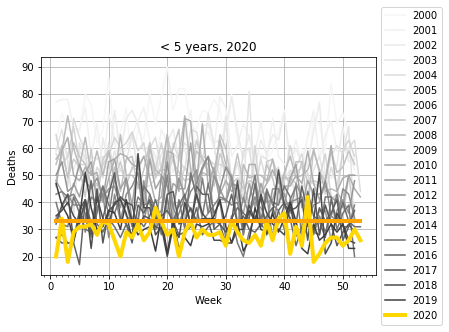

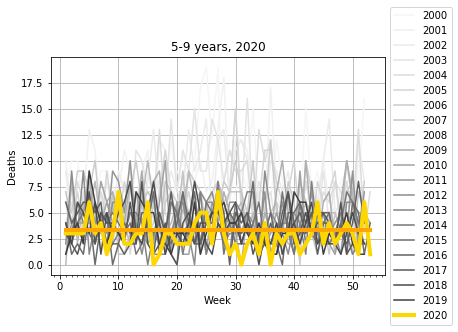

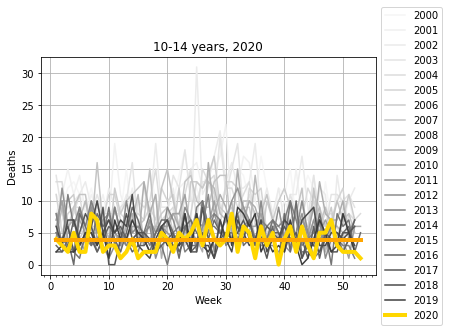

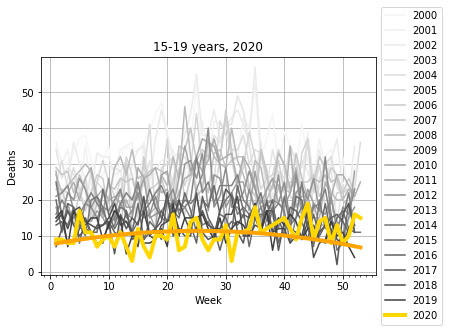

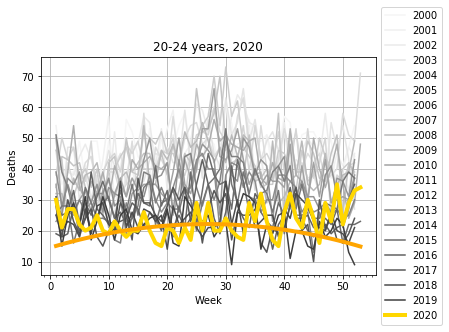

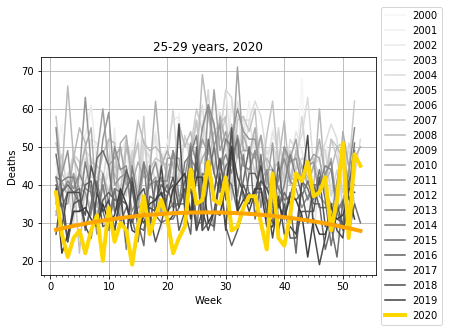

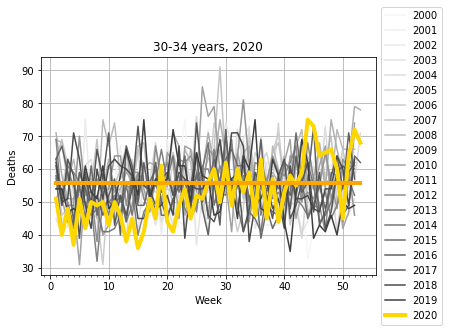

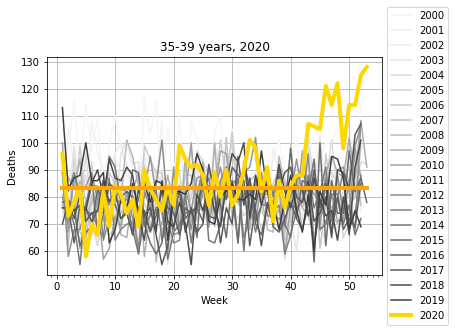

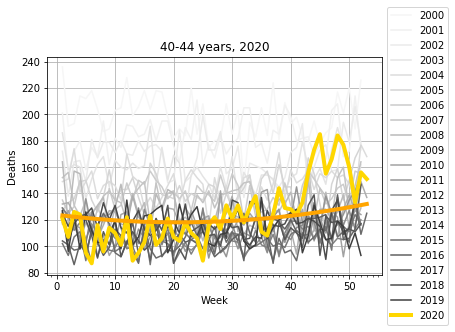

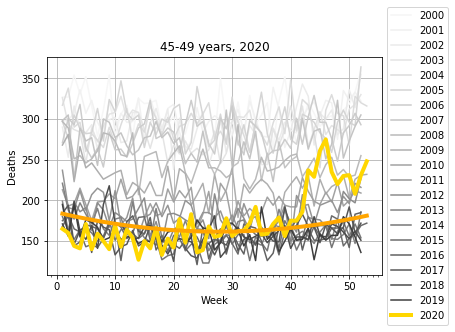

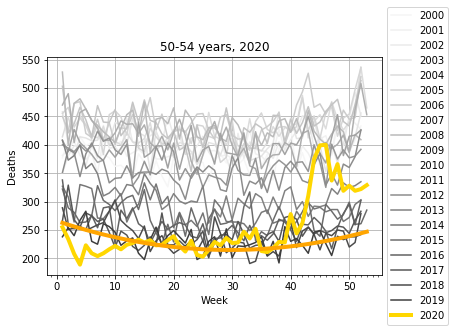

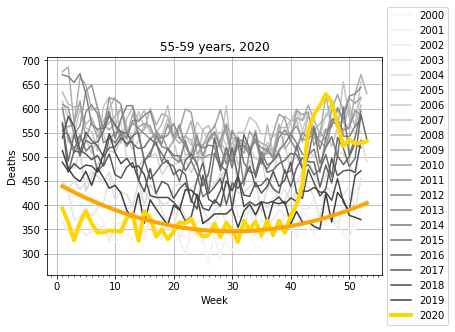

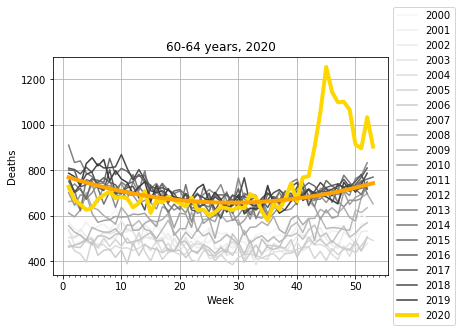

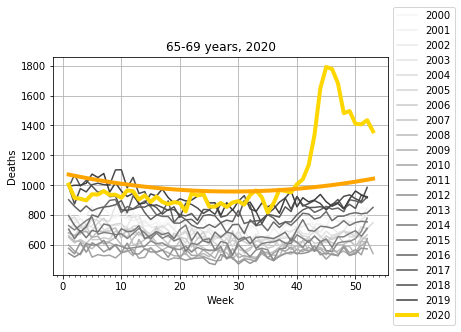

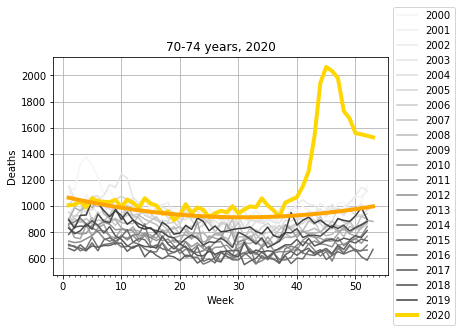

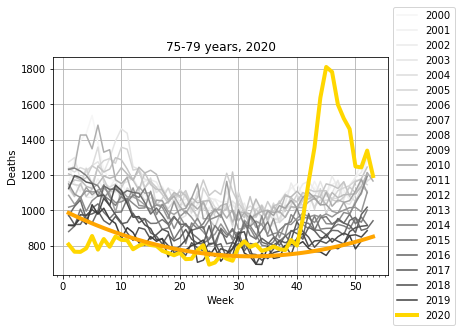

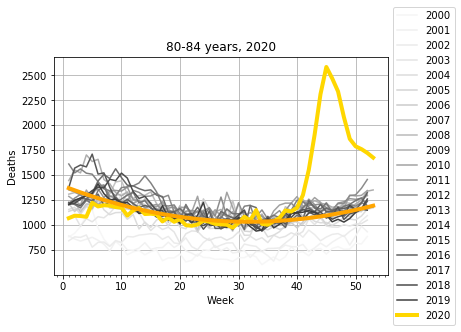

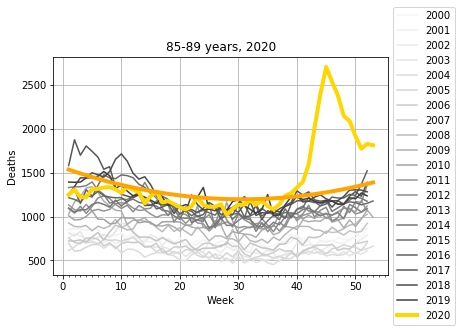

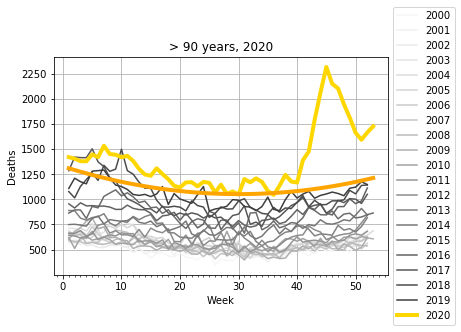

In [15]:


ylims_dict = {}
for i in range(0,95,5):
    trend = [f(2020,y, i,dfparams) for y in range(1,54) ]
    dftrend = pd.DataFrame()
    dftrend['Week'] = [y for y in range(1,54) ]
    dftrend['Trend'] = trend
    dftrend.set_index('Week', inplace=True)


    df1 = df_PL
    df1=group_by_year(df1)
    df1 = select_age_groups_by_range(df1, i,i+5)
    df2 = select_gender(df1, 'T')
    title = age_groups_verbose[i]
    years = [df2.columns[i][1] for i in range(0,len(df2.columns))]
    po = PlotOptions(ylabel='Deaths', cmap=mpl.cm.Greys, title=title + ', 2020', legend = years)
    fig,ylim =  plot_df(df2, po, dftrend=dftrend)
    ylims_dict[i] = ylim
#     format = 'svg'
#     figname =  age_groups[i] +'_group_2020'+ '.' + format
#     fig.savefig(data_dir+'/images/'+figname, format=format, bbox_inches='tight')

    

In [56]:
# ylims_dict

In [57]:
# Jakiego typu jest ylim?
# type(ylims_dict[0])

**Walidacja z 2019 rokiem:**

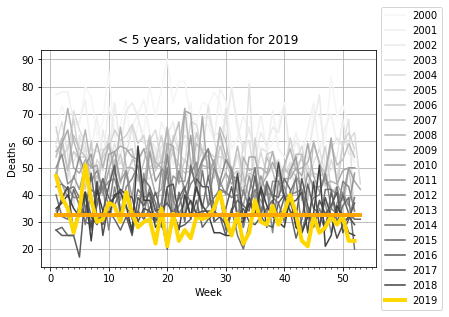

2019: Trend maximally exceeded by 56%


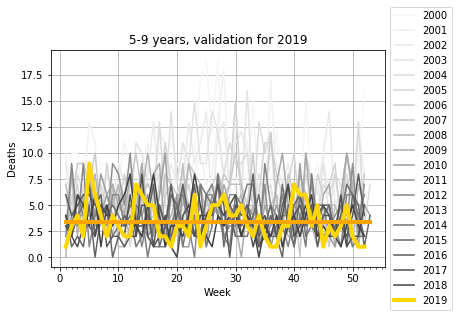

2019: Trend maximally exceeded by 166%


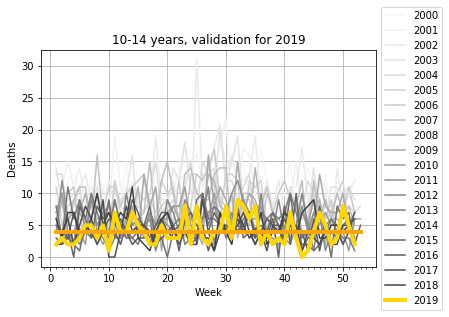

2019: Trend maximally exceeded by 124%


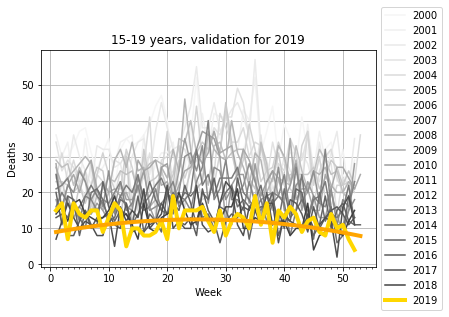

2019: Trend maximally exceeded by 53%


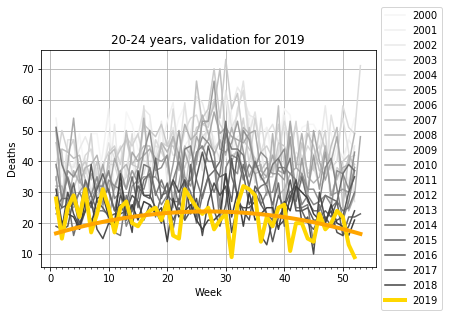

2019: Trend maximally exceeded by 37%


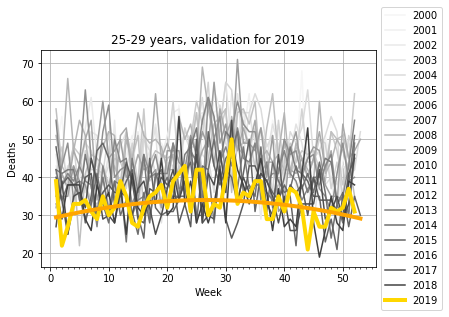

2019: Trend maximally exceeded by 48%


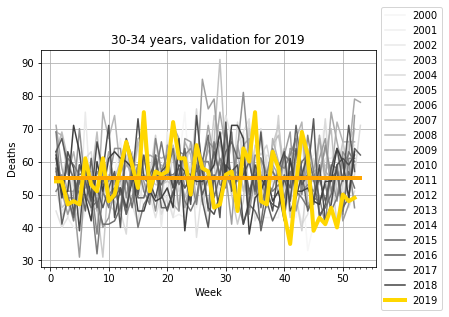

2019: Trend maximally exceeded by 37%


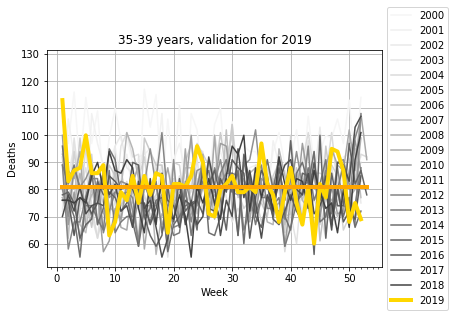

2019: Trend maximally exceeded by 39%


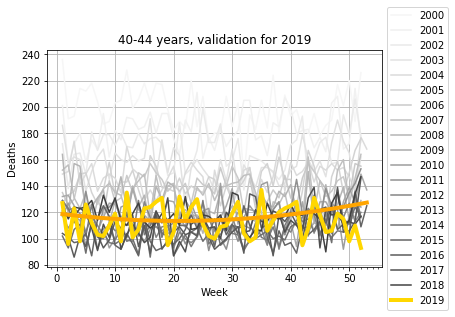

2019: Trend maximally exceeded by 18%


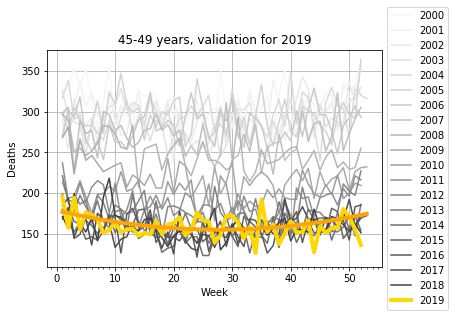

2019: Trend maximally exceeded by 10%


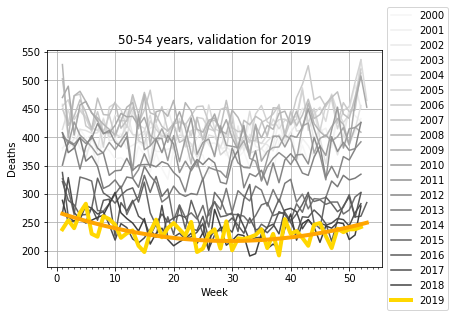

2019: Trend maximally exceeded by 12%


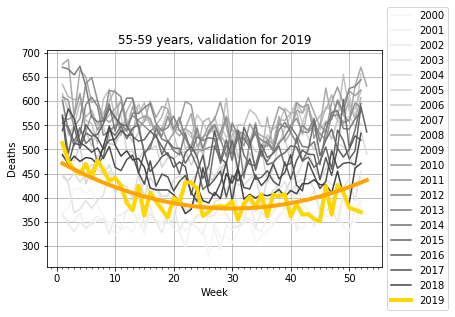

2019: Trend maximally exceeded by 9%


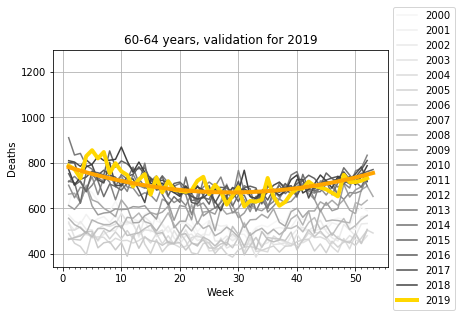

2019: Trend maximally exceeded by 14%


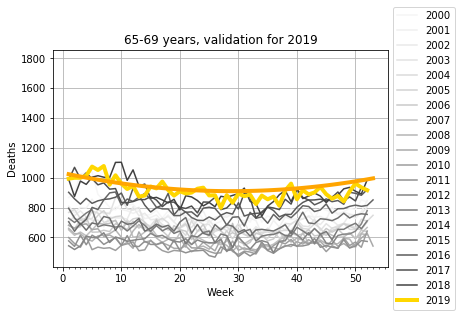

2019: Trend maximally exceeded by 10%


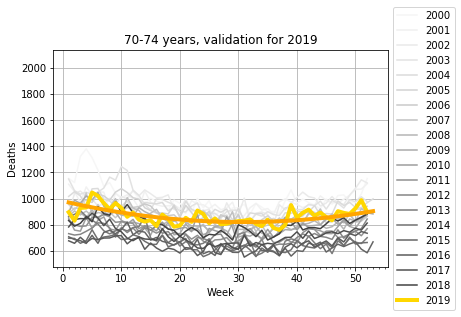

2019: Trend maximally exceeded by 12%


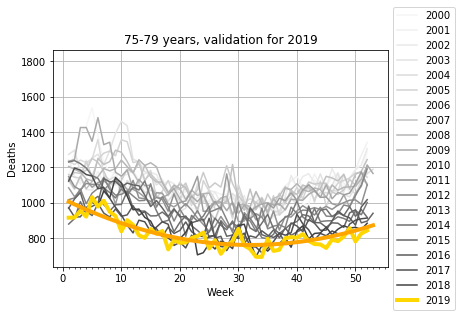

2019: Trend maximally exceeded by 9%


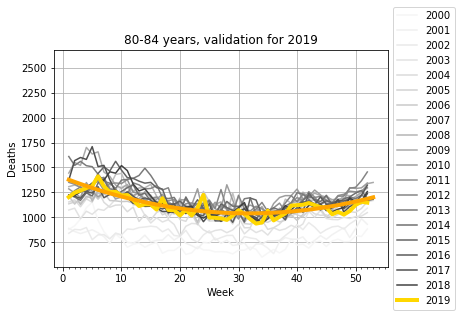

2019: Trend maximally exceeded by 11%


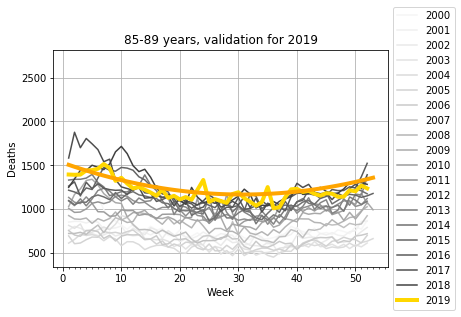

2019: Trend maximally exceeded by 10%


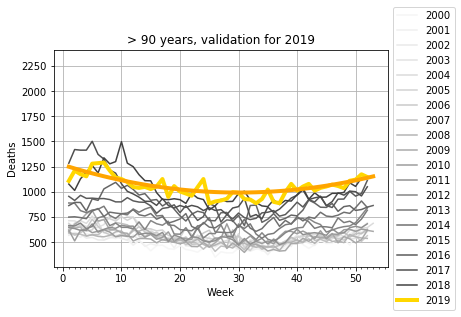

2019: Trend maximally exceeded by 12%


,Age group,2019: Trend maximally exceeded by [%]
0,Y_LT5,56.164767
1,Y5-9,165.981797
2,Y10-14,123.881404
3,Y15-19,53.332198
4,Y20-24,36.846873
5,Y25-29,47.561314
6,Y30-34,36.621918
7,Y35-39,39.428378
8,Y40-44,17.913245
9,Y45-49,10.277162


In [16]:
def trend_exceeded_ratio(df2, year):
    # https://stackoverflow.com/questions/25189575/pandas-dataframe-select-columns-in-multiindex
    idx = pd.IndexSlice
    column = df2.loc[:,idx[df2.columns[0][0],year]]
    
    column = pd.to_numeric(column)
    trend = [f(year,y, i,dfparams) for y in range(1,54) ]
    dftrend = pd.DataFrame()
    dftrend['Week'] = [y for y in range(1,54) ]
    dftrend['Value'] = trend
    dftrend.set_index('Week', inplace=True)
    
#     display(dftrend)
#     print(column.max())
#     print(column.idxmax())

    trendvalue = dftrend.loc[column.idxmax()]['Value']
#     print(trendvalue)
    trend_exceeded_ratio = (column.max() - trendvalue)/trendvalue
    return trend_exceeded_ratio


tedf=pd.DataFrame(columns=['Age group', '2019: Trend maximally exceeded by [%]'])


# display(tedf)

for i in range(0,95,5):
    trend = [f(2019,y, i,dfparams) for y in range(1,54) ]
    dftrend = pd.DataFrame()
    dftrend['Week'] = [y for y in range(1,54) ]
    dftrend['Trend'] = trend
    dftrend.set_index('Week',inplace=True)


    df1 = df_PL
    df1=group_by_year(df1)
    df1 = select_age_groups_by_range(df1, i,i+5)
    df2 = select_gender(df1, 'T')
    title = age_groups_verbose[i]
    years = [df2.columns[i][1] for i in range(0,len(df2.columns)-1)]
    idx = pd.IndexSlice
    df3 = df2.loc[:,idx[:,years]]
    po = PlotOptions(ylabel='Deaths', cmap=mpl.cm.Greys, title=title+', validation for 2019', legend = years,\
                     ylim=ylims_dict[i])
    fig,ylim1 = plot_df(df3, po, dftrend=dftrend)
#     print(ylim1)
    format = 'svg'
    figname = age_groups[i] + '_group_2019'+ '.' + format
    fig.savefig(data_dir+'/images/'+figname, format=format, bbox_inches='tight')
    te2019=trend_exceeded_ratio(df2, 2019)*100
    print(f'2019: Trend maximally exceeded by {te2019:.0f}%')
    tedf_new_row ={ 'Age group':age_groups[i], '2019: Trend maximally exceeded by [%]':te2019}
    tedf = tedf.append(tedf_new_row, ignore_index=True)
#     display(tedf_new_row)
display(tedf)
tedf.to_csv(data_dir + '/'+ 'tedf2019.csv', index=False, na_rep='NaN')

In [59]:
# # custom data_dir

# os.system('cd ' + data_dir + ';\
#           mv Y*.png ./images/')

In [60]:
# os.system("./change_png_file_names.sh " + data_dir )

In [61]:
# Dodać skrypty tworzące raport

In [62]:
### os.system("./make_pdf.sh " + data_dir )

In [63]:
## comments = 'zgony_grupy_wiekowe_komentarz1.pdf'
## plots = 'plots_a4_2x4.pdf'
## appendix = 'appendix.pdf'
## output = 'zgony_grupy_wiekowe_komentarz_appendix2.pdf'

## command = "./merge_comments_plots_appendix.sh %s %s %s %s %s" % (data_dir, comments, plots, appendix, output)

## os.system(command)

In [69]:
# Sezonowość może po prostu nie pasować do tej prostej funkcji
# Dodać trend do legendy
# Opisać, na jakiej zasadzie wybierałam funkcję do fitowania, liniową czy kwadratową - gdy błąd był ...

# Na oko, trend jest przekrzywiony, bo minimum sezonowe jest w 30. tygodniu, a nie w 27.
# Albo zmienić dataframe z multiindex na normalną, albo napisać funkcję wybierającą kolumny.
### Dodać do trendu +/- błąd!!!